In [1]:
from train_test import train, test

from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl

from dateutil.relativedelta import relativedelta

import shap

from captum.attr import IntegratedGradients, ShapleyValues, ShapleyValueSampling

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

torch.manual_seed(0)
np.random.seed(0)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
def output_to_accu(model, X, y):
    model.eval()
    prob = model(X).cpu().detach().numpy()
    index = np.where((prob > 0.6) | (prob < 0.4))
    prob = prob[index]
    y = y[index]
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, len(y)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / len(y))
    return accuracy

In [4]:
def good_bad_pred(model, X_test, y_test):
    model.eval()
    prob = model(X_test).detach().numpy()
    pred = (prob >= 0.5).astype(int)
    return (pred == y_test.detach().numpy()).astype(int)

In [5]:
def fast_fracdiff(x, d):

    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [6]:
red = sns.color_palette('RdYlGn', 10)[0]
green = sns.color_palette('RdYlGn', 10)[-1]
pal = [red, green]
color_dict = {'Bad':pal[0], 'Good':pal[1]}

# DATA

In [7]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').astype(float)
data = data.fillna(method='ffill').shift(1).iloc[1:]
data = data.loc[:'2020-01-01']

data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']

data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

bench_price = data['SPI']

data = data.drop(columns=['EURCHF', 'USDCHF', 'SPI', 'SURPRISE'])

data.head()

,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000
2006-01-05,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796
2006-01-06,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911
2006-01-09,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961
2006-01-10,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117
2006-01-11,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507


In [8]:
target_prices = data[['SMALL_MID', 'LARGE']]
target_prices.head()

,SMALL_MID,LARGE
2006-01-05,1508.31,5833.18
2006-01-06,1509.53,5818.60
2006-01-09,1516.33,5828.32
2006-01-10,1518.68,5823.36
2006-01-11,1512.24,5785.15


In [9]:
technical_features = data[['SMALL_MID', 'LARGE']]

mom5 = technical_features.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom63 = mom63.add_suffix(' mom63')

vol21 = technical_features.rolling(21).std()
vol21 = vol21.add_suffix(' vol21')

features = pd.DataFrame(index=technical_features.index)
for feature in (set(data.columns) - set(technical_features)):
    #features[feature] = fast_fracdiff(data[feature], 0.5)
    features[feature] = data[feature].rolling(10).apply(lambda x: np.log(x[-1] / x[0]) / len(x))

features = pd.concat([mom5, mom21, mom63, vol21, features], axis=1).ewm(5).mean().dropna()

# features['monday'] = (features.index.weekday == 0).astype(int)
# features['tuesday'] = (features.index.weekday == 1).astype(int)
# features['wednesday'] = (features.index.weekday == 2).astype(int)
# features['thrusday'] = (features.index.weekday == 3).astype(int)
# features['friday'] = (features.index.weekday == 4).astype(int)

features.head(5)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,MATERIALS,CONSUMER DIS.,BRENT,SILVER,US 10YEAR,INDUSTRIALS,GOLD,US 2YEAR,HEALTH CARE,RUSSELL 2000,FINANCIALS,CONSUMER STAPLE,US 5YEAR,SP500
2006-04-03,0.001734,-0.000138,0.001987,0.000582,0.001972,0.000648,25.390740,53.921756,0.002805,0.001919,0.003514,0.007209,0.001727,0.001546,0.002805,0.001924,0.000926,0.002431,0.001015,-0.000097,0.001764,0.000562
2006-04-04,0.001879,0.000316,0.002005,0.000638,0.002031,0.000723,26.267809,53.687732,0.003125,0.001847,0.004173,0.008138,0.001944,0.001642,0.003484,0.001976,0.000890,0.002568,0.000875,-0.000151,0.001957,0.000503
2006-04-05,0.002176,0.000543,0.002121,0.000708,0.002041,0.000715,27.314992,53.259544,0.003328,0.001556,0.004573,0.008517,0.002195,0.001708,0.003803,0.001932,0.000434,0.002347,0.000656,-0.000319,0.002083,0.000250
2006-04-06,0.002428,0.000679,0.002302,0.000829,0.002060,0.000741,28.355331,52.189743,0.003426,0.001264,0.004382,0.008297,0.002212,0.001680,0.003881,0.001718,0.000179,0.001959,0.000520,-0.000467,0.001946,-0.000073
2006-04-07,0.002594,0.000873,0.002454,0.000916,0.002100,0.000792,29.164290,49.851159,0.003338,0.000890,0.004486,0.008497,0.002644,0.001606,0.003929,0.001868,-0.000138,0.001639,0.000430,-0.000695,0.002246,-0.000248


In [10]:
features = features.drop(columns=['SMALL_MID mom21', 'LARGE vol21', 'US 5YEAR', 'MATERIALS'])

In [11]:
training_window = 5
neutral_threshold = 0.0005
last_date_train = target_prices.index[-1200]

In [12]:
forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['difference'] = forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.difference)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)
best_pred = best_pred[forward_weekly_returns.abs_diff > neutral_threshold]

start_date = last_date_train - relativedelta(years=training_window)

df_output = best_pred.loc[start_date:last_date_train]
df_input = features.reindex(df_output.index)

X = df_input.values
y = df_output.values

index = df_input.index

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

print('start_date', index[0].date(), 'last_date', index[-1].date())

start_date 2010-05-28 last_date 2015-05-28


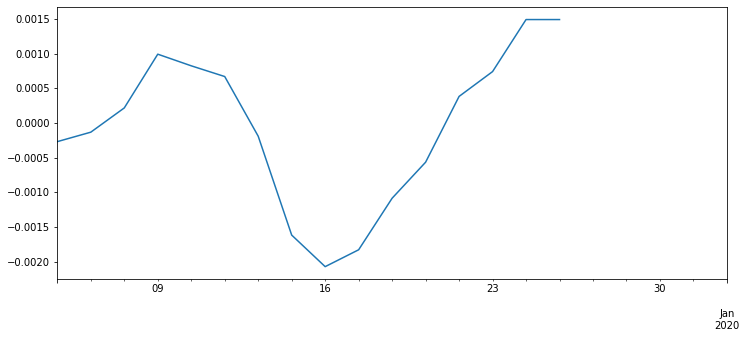

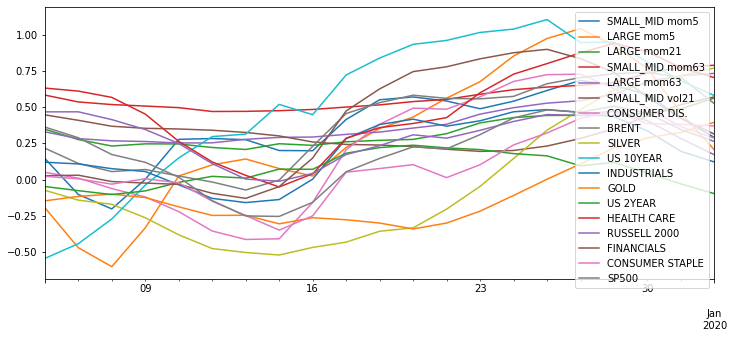

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
forward_weekly_returns.difference[-21:].plot(ax=ax)

features_standardized = (features - features.mean()) / features.std()
fig, ax = plt.subplots(figsize=(12, 5))
features_standardized[-21:].plot(ax=ax)

plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size= 0.2, shuffle=False)
print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

class_count_train = np.unique(y_train, axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test, axis=0, return_counts=True)[1]
weights_train = class_count_train / sum(class_count_train)
weights_test = class_count_test / sum(class_count_test)
print('Allocation of best returns in train set :', weights_train)
print('Allocation of best returns in test set :', weights_test)

Number of train sample : 805
Number of test sample : 202
Allocation of best returns in train set : [0.518 0.482]
Allocation of best returns in test set : [0.495 0.505]


# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size= 0.2, shuffle=False)

In [17]:
rfc = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=10, 
                             min_samples_split=10, n_estimators= 100)

rfc = rfc.fit(X_train, y_train)
y_hat_rfc_train = rfc.predict(X_train)
y_hat_rfc_test = rfc.predict(X_test)

print('Accuracy on train set', round(100 * accuracy_score(y_hat_rfc_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_rfc_test, y_test), 2), '%')

Accuracy on train set 91.18 %
Accuracy on test set 38.12 %


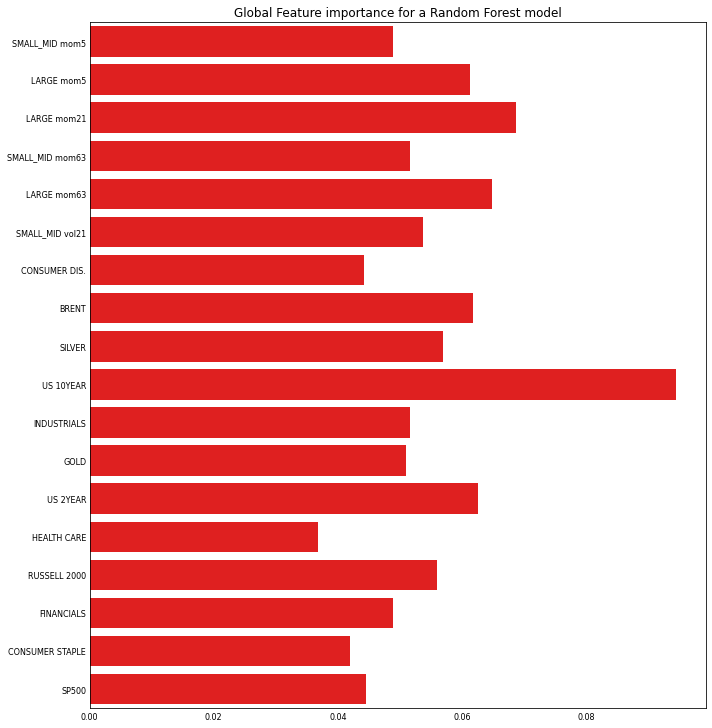

In [18]:
importances = rfc.feature_importances_

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y=features.columns, x=importances, color='r')
ax.tick_params(labelsize=8, length=0)
plt.tight_layout()
plt.title('Global Feature importance for a Random Forest model')
plt.show()

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
xgboost = GradientBoostingClassifier(max_depth=1, n_estimators= 1000)

xgboost = xgboost.fit(X_train, y_train)
y_hat_xgboost_train = xgboost.predict(X_train)
y_hat_xgboost_test = xgboost.predict(X_test)

print('Accuracy on train set', round(100 * accuracy_score(y_hat_xgboost_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_xgboost_test, y_test), 2), '%')

Accuracy on train set 84.84 %
Accuracy on test set 45.05 %


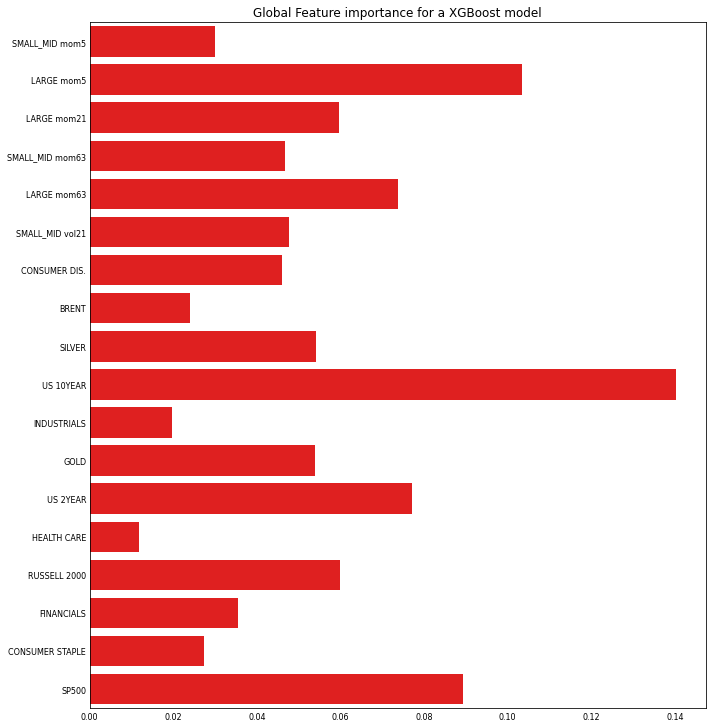

In [20]:
importances = xgboost.feature_importances_

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y=features.columns, x=importances, color='r')
ax.tick_params(labelsize=8, length=0)
plt.tight_layout()
plt.title('Global Feature importance for a XGBoost model')
plt.show()

In [21]:
explainer = shap.TreeExplainer(rfc)
shap_values_train = np.mean(explainer.shap_values(X_train), axis=0)
shap_values_test = np.mean(explainer.shap_values(X_test), axis=0)

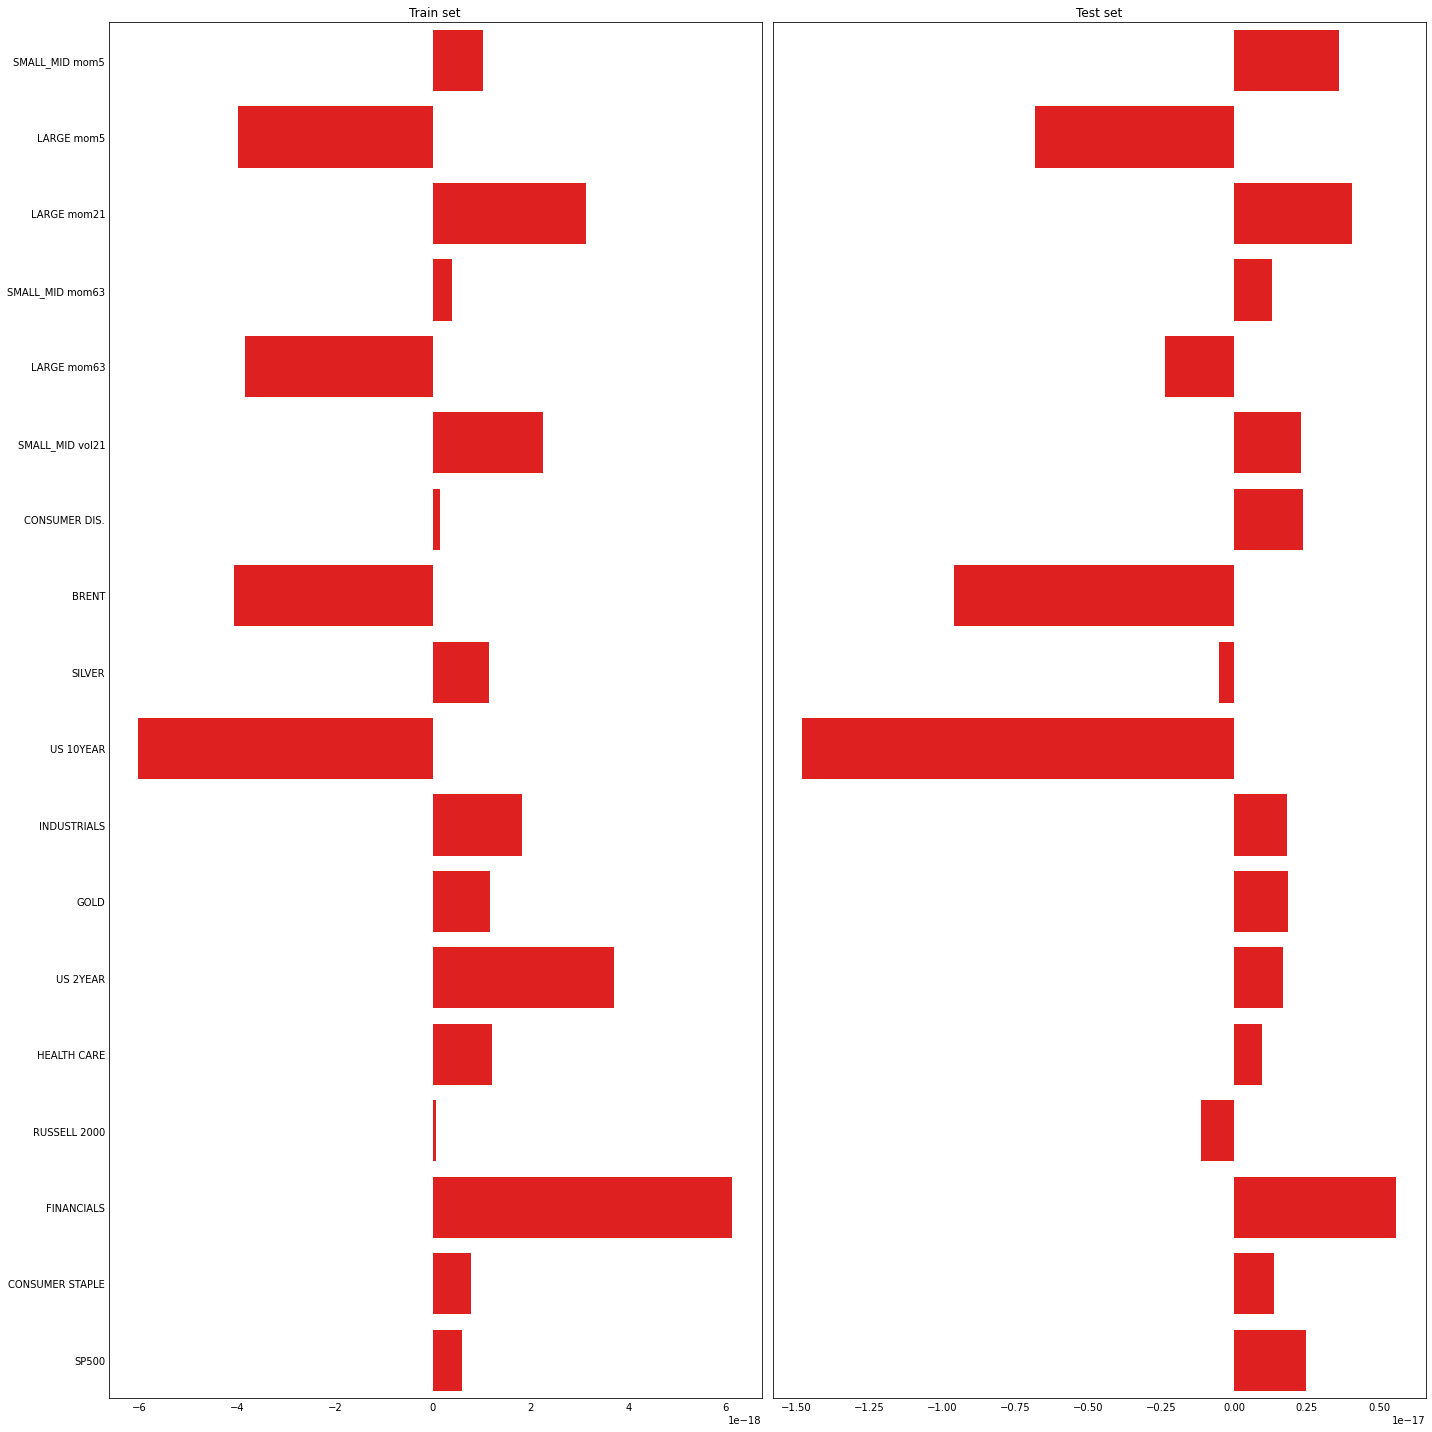

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 20), sharey=True)

sns.barplot(ax=axs[0], x=shap_values_train.mean(axis=0), y=features.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=shap_values_test.mean(axis=0), y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

In [23]:
def good_bad_pred_rf(model, X_test, y_test):
    pred = model.predict(X_test)
    return (pred == y_test).astype(int)

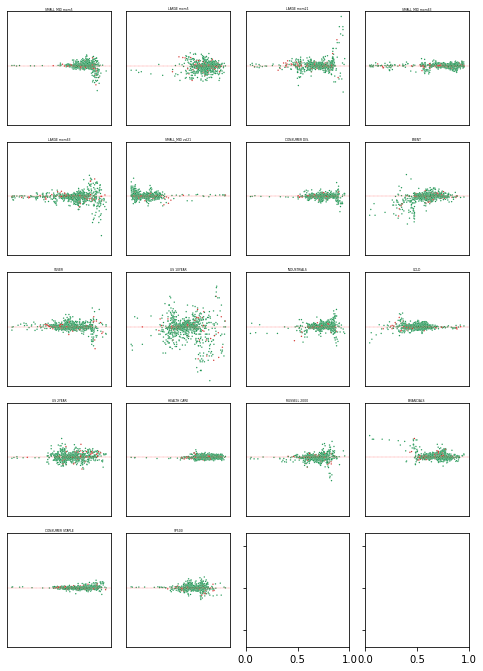

In [24]:
shap_values = shap_values_train
good_bad = good_bad_pred_rf(rfc, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/RF_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

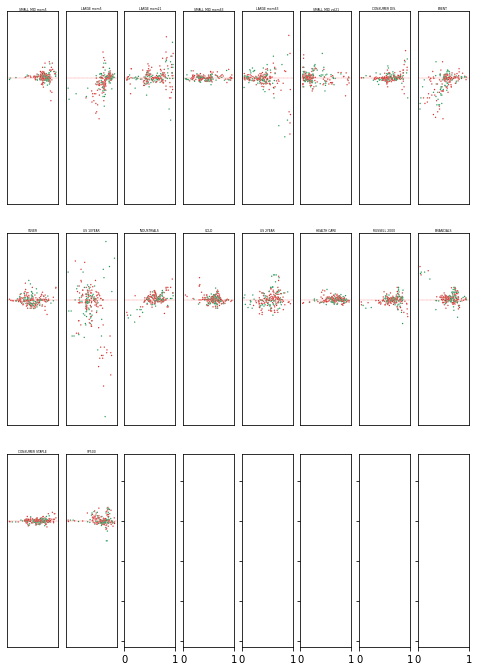

In [25]:
shap_values = shap_values_test
good_bad = good_bad_pred_rf(rfc, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 8), 8, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test[:, i]
    df['IG'] = shap_values[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, legend=False, palette=color_dict)

    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('plots/RF_features_importances_test.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [26]:
list(features.columns)

['SMALL_MID mom5',
 'LARGE mom5',
 'LARGE mom21',
 'SMALL_MID mom63',
 'LARGE mom63',
 'SMALL_MID vol21',
 'CONSUMER DIS.',
 'BRENT',
 'SILVER',
 'US 10YEAR',
 'INDUSTRIALS',
 'GOLD',
 'US 2YEAR',
 'HEALTH CARE',
 'RUSSELL 2000',
 'FINANCIALS',
 'CONSUMER STAPLE',
 'SP500']

# Neural Networks

In [27]:
class MLP(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size=10):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))       

        return x.squeeze()

In [28]:
train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]

X_mean = X_train.mean(dim=[0], keepdim=True)
X_std = X_train.std(dim=[0], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

print('Number of train sample', len(X_train))
print('Number of test sample', len(X_test))

print('Train period :', index[train_indices][0].date(), 'to', index[train_indices][-1].date())
print('Test period :', index[test_indices][0].date(), 'to', index[test_indices][-1].date())

Number of train sample 805
Number of test sample 202
Train period : 2010-05-28 to 2014-05-13
Test period : 2014-05-14 to 2015-05-28


In [29]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.2
batch_size = 20
nb_epochs = 100

verbose = 3

nbr_features = X.size(1)

model_MLP = MLP(nbr_features, pdrop=dropout)

train(model_MLP, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_MLP.eval()
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP, X_test, y_test):.2f} %')

100%|██████████| 100/100 [00:05<00:00, 16.73it/s]

 MLP Accuracy on train set : 83.79 %
 MLP Accuracy on test set : 45.78 %


In [30]:
def IG_barplot(model_list, X_test):  
    
    fig, axs = plt.subplots(1, len(model_list), figsize=(20,30), sharex=True, sharey=True)
    axs = axs.ravel()
    for i, model in enumerate(model_list):
        model.eval()
        ig = IntegratedGradients(model)
        attr = np.abs(ig.attribute(X_test, return_convergence_delta=False).detach().numpy())
        std = np.std(attr, axis=0)
        
        attr_matrix = np.mean(np.abs(attr), axis=0)

        sns.barplot(ax=axs[i], y=features.columns, x=attr_matrix, yerr=std, color='r', orient='h')
        axs[i].tick_params(length=0)
        axs[i].set_title(model.__class__.__name__)

    plt.show()

In [31]:
ig = IntegratedGradients(model_MLP)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

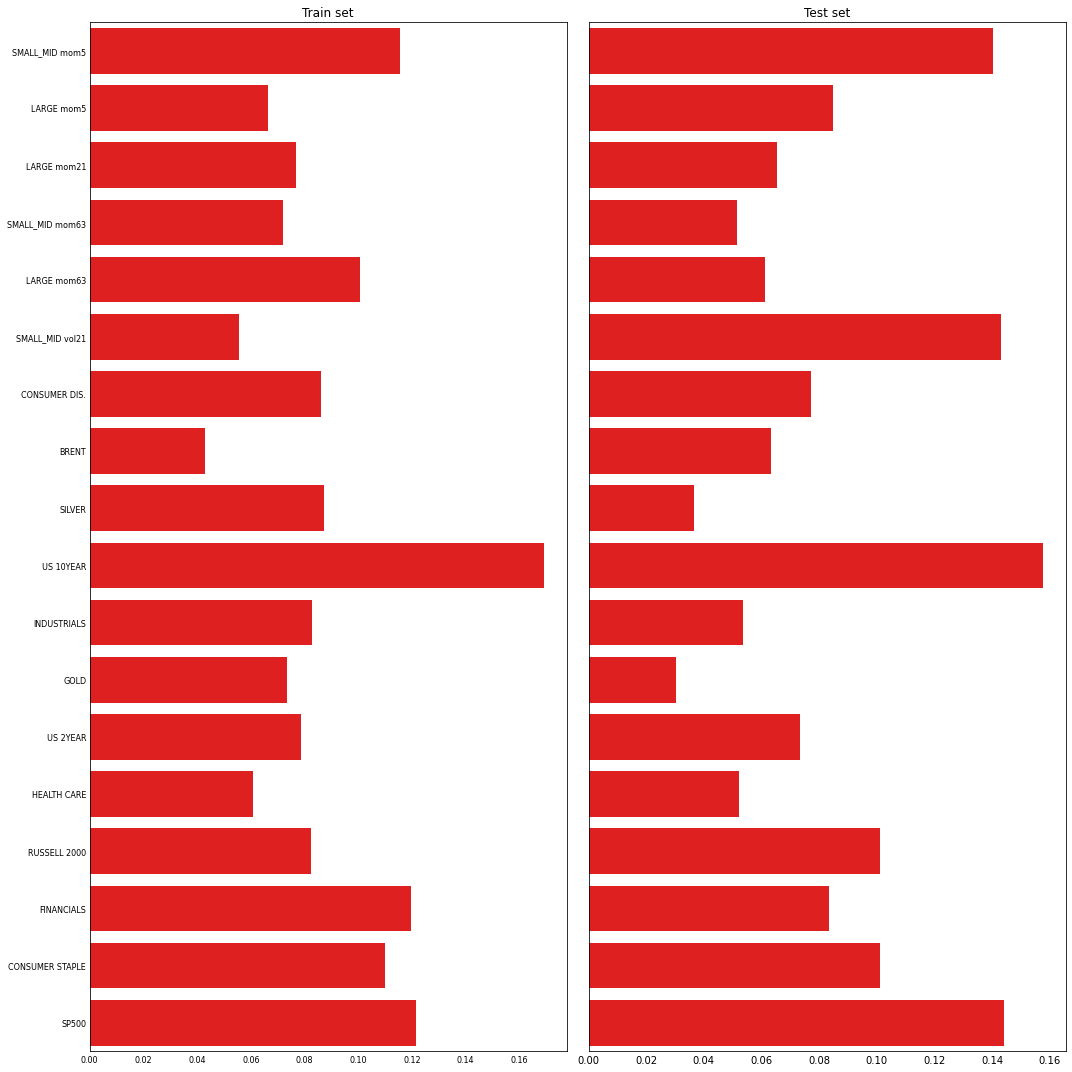

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True)

attr_train = np.mean(np.abs(attributes_train), axis=0)
attr_test = np.mean(np.abs(attributes_test), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

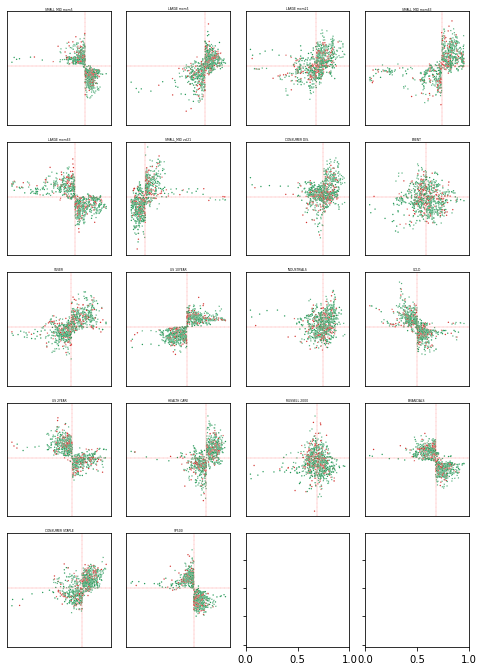

In [34]:
good_bad = good_bad_pred(model_MLP, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i] / np.sum(np.abs(attributes_train[:, i])) / np.abs(X_train[:, i])
    df['GOOD_BAD'] = good_bad
    df['target'] = y_train
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({1:'Large', 0:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target', s=2, 
                    palette=color_dict, legend=False, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/MLP_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

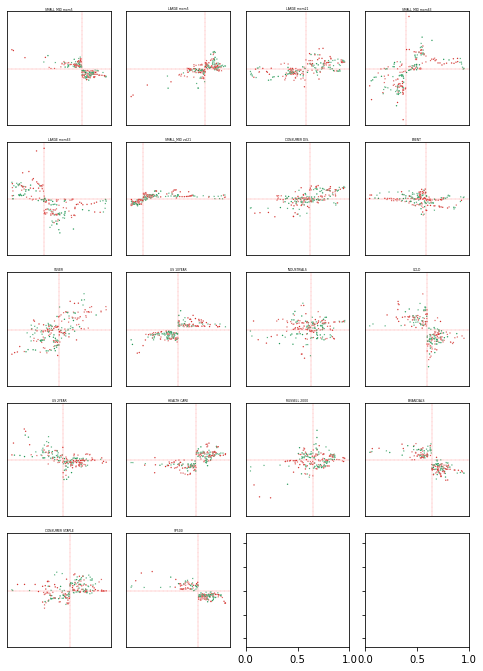

In [35]:
good_bad = good_bad_pred(model_MLP, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test[:, i]
    df['IG'] = attributes_test[:, i] / np.sum(np.abs(attributes_test[:, i])) / np.abs(X_test[:, i])
    df['GOOD_BAD'] = good_bad
    df['target'] = y_test
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({1:'Large', 0:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, style='target',
                    palette=list(reversed(pal)), legend=False, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('plots/MLP_features_importances_test.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')

plt.show()

# Time series as an input

In [36]:
features_standardized = (features - features.mean()) / features.std()
mom5 = features_standardized[features_standardized.columns[:11]]
mom21 = features_standardized[features_standardized.columns[11:22]]

In [37]:
class RNN(nn.Module):

    def __init__(self, nbr_features, hidden_size, num_layers, pdrop=0.):
        super(RNN, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.rnn = nn.RNN(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.rnn(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()


class GRU(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=1, pdrop=0.):
        super(GRU, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.gru = nn.GRU(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.gru(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()


class LSTM(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=1, pdrop=0.):
        super(LSTM, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [38]:
input_period = 21

num_features = len(features.columns)

df_input = features.loc[:df_output.index[-1]]

X = []
for idx in df_output.index:
    df_input_period = df_input.loc[:idx].iloc[-input_period:]
    X_period = df_input_period.values.reshape(input_period, num_features)
    X.append(X_period)

X = np.array(X)
y = df_output.values

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]
print('Number of train sample', len(X_train))
print('Number of test sample', len(X_test))

X_mean = X_train.mean(dim=[0, 1], keepdim=True)
X_std = X_train.std(dim=[0, 1], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

class_count_train = np.unique(y_train.cpu(), axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test.cpu(), axis=0, return_counts=True)[1]
weights_train = torch.tensor(class_count_train / sum(class_count_train))
weights_test = torch.tensor(class_count_test / sum(class_count_test))
print('Allocation of best returns in train set :', weights_train.cpu().numpy())
print('Allocation of best returns in test set :', weights_test.cpu().numpy())

Number of train sample 805
Number of test sample 202
Allocation of best returns in train set : [0.518 0.482]
Allocation of best returns in test set : [0.495 0.505]


In [45]:
eta = 1e-3
weight_decay = 5e-4
dropout = 0.
batch_size = 20
nb_epochs = 15

verbose = 3

nbr_features = X.size(2)
hidden_size = 20
num_layers = 1

model_RNN = RNN(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
model_GRU = GRU(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
model_LSTM = LSTM(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)

train(model_RNN, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_GRU, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_LSTM, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_RNN.eval()
print(f' RNN Accuracy on train set : {output_to_accu(model_RNN, X_train, y_train):.2f} %')
print(f' RNN Accuracy on test set : {output_to_accu(model_RNN, X_test, y_test):.2f} %')

model_GRU.eval()
print(f' GRU Accuracy on train set : {output_to_accu(model_GRU, X_train, y_train):.2f} %')
print(f' GRU Accuracy on test set : {output_to_accu(model_GRU, X_test, y_test):.2f} %')

model_LSTM.eval()
print(f' LSTM Accuracy on train set : {output_to_accu(model_LSTM, X_train, y_train):.2f} %')
print(f' LSTM Accuracy on test set : {output_to_accu(model_LSTM, X_test, y_test):.2f} %')

100%|██████████| 15/15 [00:01<00:00,  7.70it/s]


 RNN Accuracy on train set : 77.60 %
 RNN Accuracy on test set : 41.83 %
 GRU Accuracy on train set : 81.39 %
 GRU Accuracy on test set : 40.61 %
 LSTM Accuracy on train set : 83.28 %
 LSTM Accuracy on test set : 48.72 %


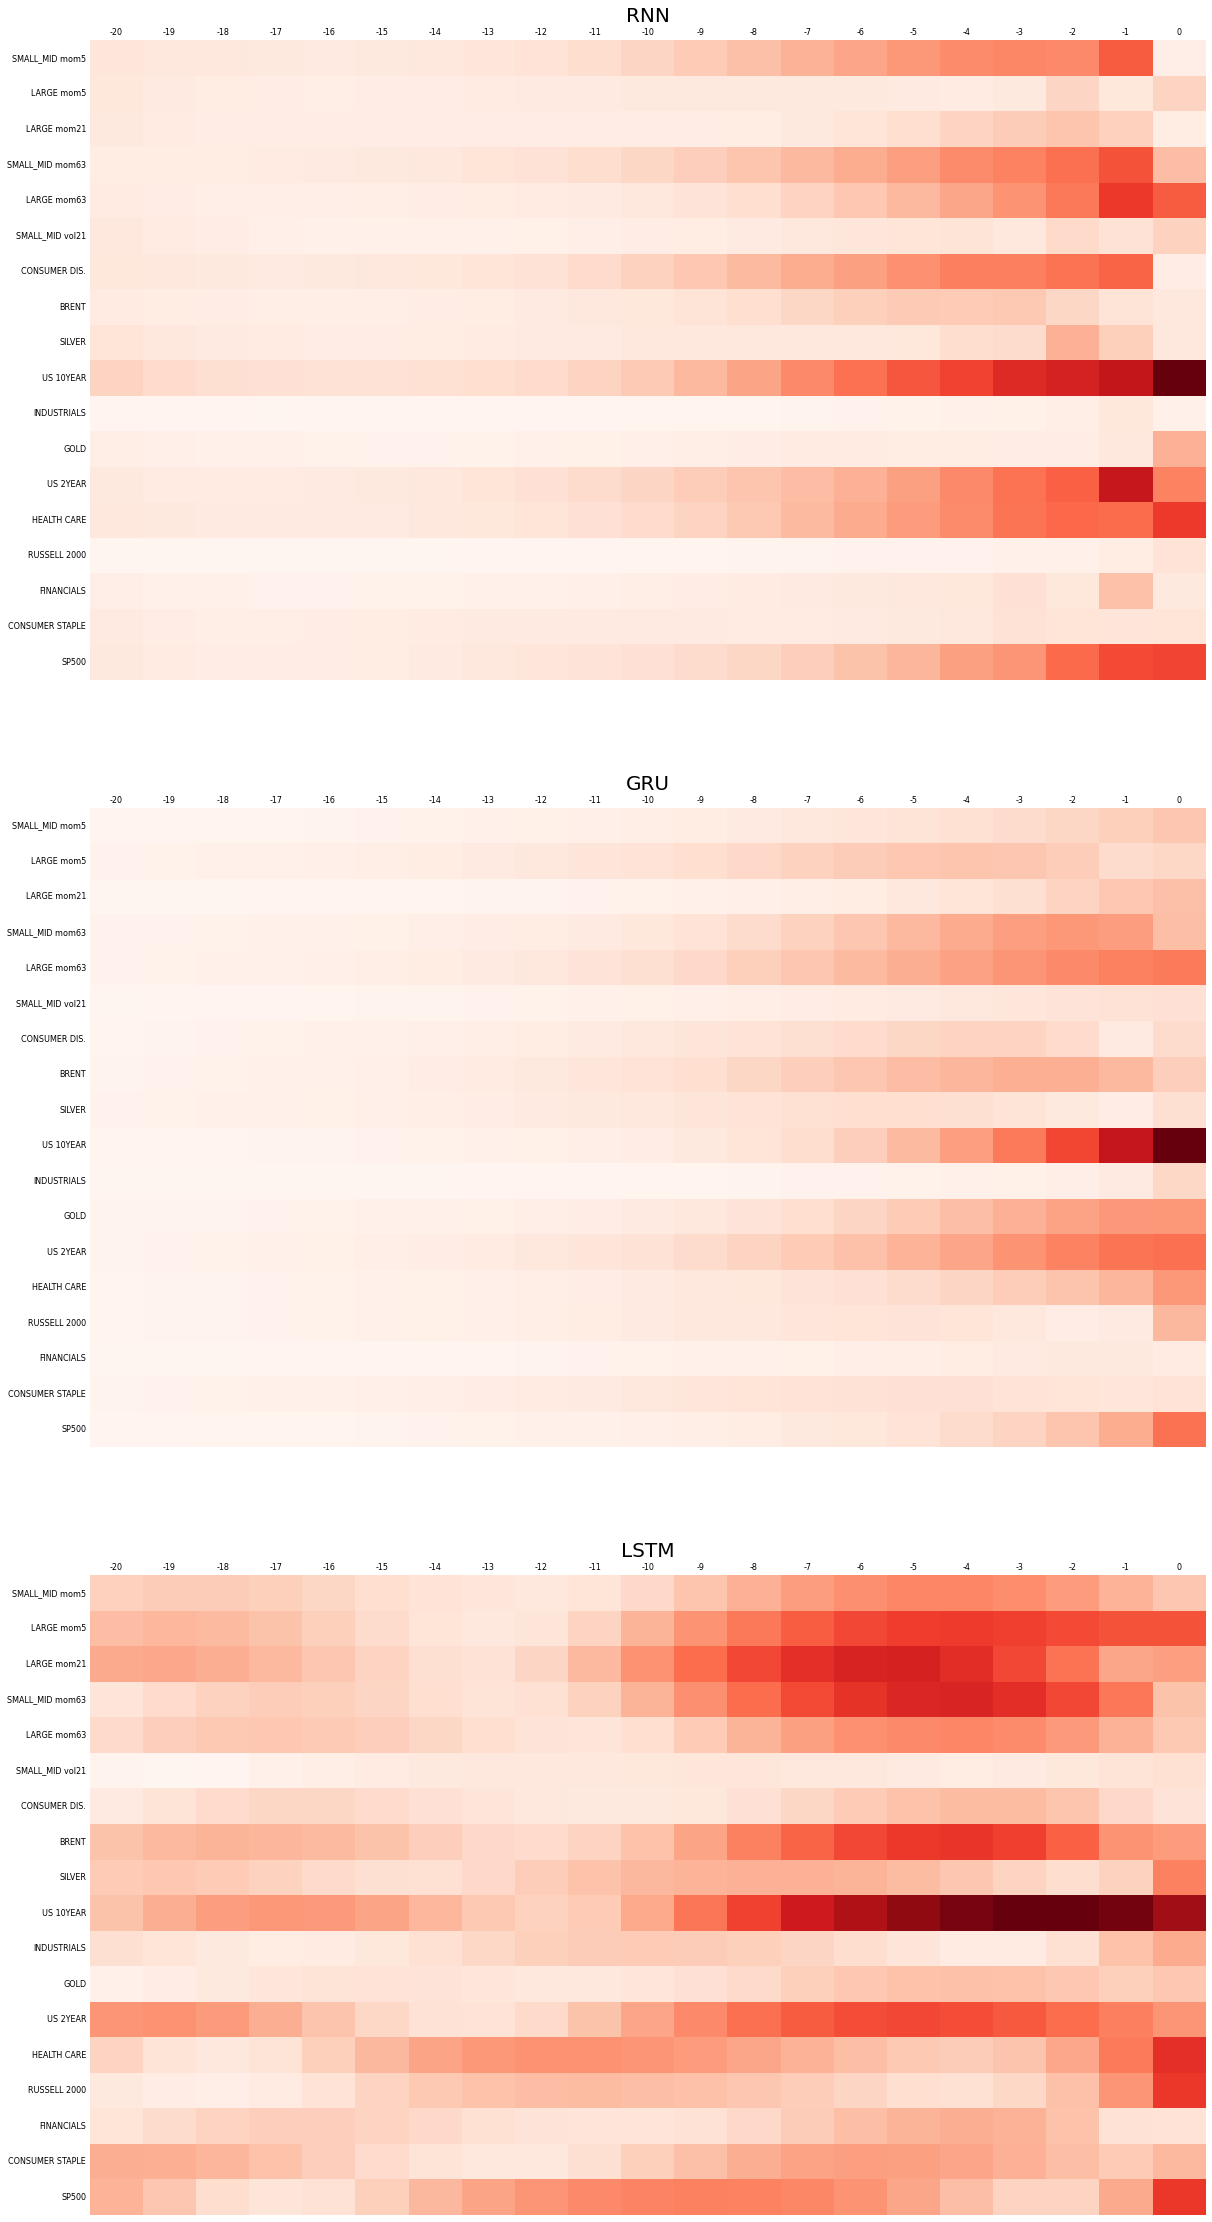

In [40]:
model_list = [model_RNN, model_GRU, model_LSTM]

fig, axs = plt.subplots(3, 1, figsize=(20, 40), sharex=True, sharey=True)
for ax, model in zip(axs, model_list):
    ig = IntegratedGradients(model)
    attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

    attr = np.mean(np.abs(attributes_train), axis=0).T

    sns.heatmap(ax=ax, data=attr, annot=False, cmap='Reds', cbar=False, 
                yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period)))))

    ax.tick_params(axis='both', which='major', labelsize=8, labeltop=True, labelbottom=False, rotation=0, length=0)
    ax.set_title(model.__class__.__name__, fontsize=20)

plt.show()

In [41]:
ig = IntegratedGradients(model_LSTM)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

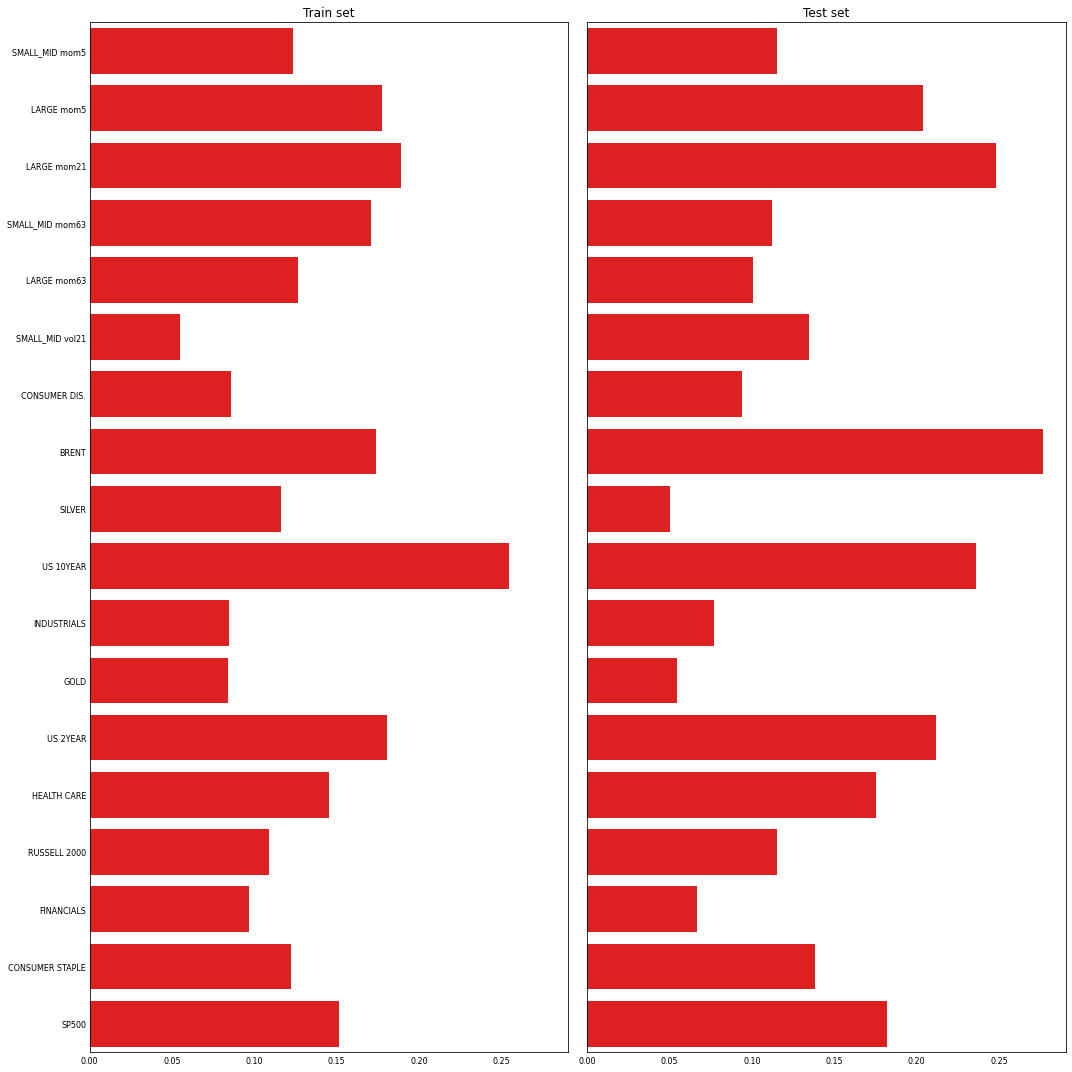

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)

attr_train = np.sum(np.mean(np.abs(attributes_train), axis=0), axis=0)
attr_test = np.sum(np.mean(np.abs(attributes_test), axis=0), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0, labelsize=8)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (805,18) (805,) 

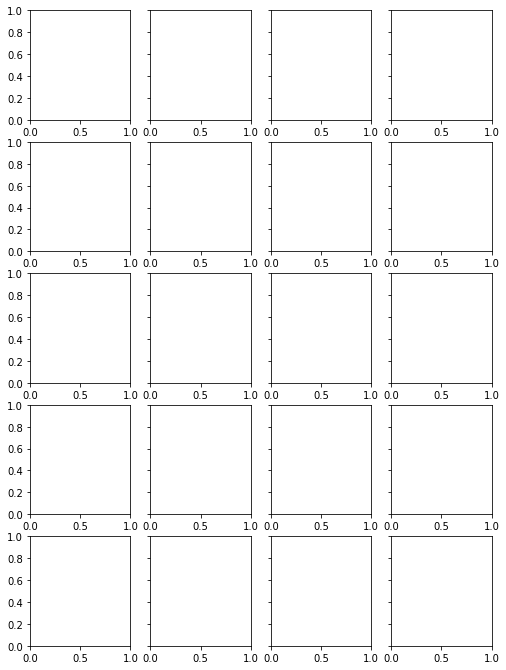

In [43]:
good_bad = good_bad_pred(model_LSTM, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_train, axis=1)[:, i]  / np.sum(np.abs(attributes_train[:, i])) / np.abs(X_train[:, i])
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df['target'] = y_train
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=color_dict)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

In [ ]:
good_bad = good_bad_pred(model_LSTM, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_test, axis=1)[:, i] / np.sum(np.abs(attributes_test[:, i])) / np.abs(X_test[:, i])
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df['target'] = y_test
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=color_dict)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_test.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

In [ ]:
fix, ax = plt.subplots(figsize=(15, 5))

plt.plot(model_LSTM(X_train).detach().numpy()[-252:])
ax.axhline(y=0.7, linestyle='--', color='r')
ax.axhline(y=0.3, linestyle='--', color='r')
plt.show()

In [ ]:
df_prob = pd.DataFrame(model_LSTM(X_train)[-252:].detach())
portfolio = pd.DataFrame(index=df_prob.index, columns=['SMALL_MID', 'LARGE']).fillna(0)

portfolio['SMALL_MID'] = (df_prob > 0.7).astype(int) - (df_prob < 0.3).astype(int)
portfolio['LARGE'] = - portfolio.SMALL_MID
portfolio.head()

In [ ]:
df_trade = pd.DataFrame(index=df_prob.index)
df_trade['small'] = (df_prob > 0.7).astype(int)
df_trade['large'] = (df_prob < 0.3).astype(int)

for i in range(len(df_trade)):
    if df_trade.small.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 1
    elif df_trade.large.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 0
    else:
        df_trade.at[i, 'strat'] = np.nan

df_trade.strat = df_trade.strat.fillna(method='ffill')
df_trade.head(20)